In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import scipy.stats as st
import matplotlib
import pickle
import scipy
from scipy.optimize import curve_fit

Using TensorFlow backend.


Initialized TensorFlow


In [3]:
def gkern(kernlen=20, nsig=3):
    """Returns a 2D Gaussian kernel."""
    # https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    
    # normalizing
    #kern1d = kern1d / np.max(kern1d)
    
    kern1d = kern1d / np.sum(kern1d)
    
    # difference kernel
    kern1d = kern1d - kern1d.sum() / kernlen
    
    return kern1d

In [4]:
sum(gkern(kernlen=200))

3.469446951953614e-18

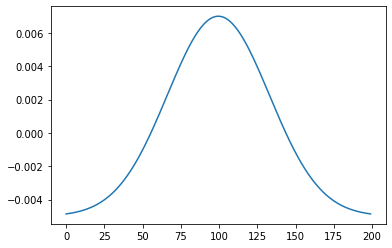

In [5]:
plt.plot(gkern(kernlen=200))

In [6]:
# W: out x in
W = np.random.randn(50, 10)
W = np.mean(scipy.ndimage.imread('/localhome/volodin/Lenna.png'), axis = 2)

/localhome/volodin/miniconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


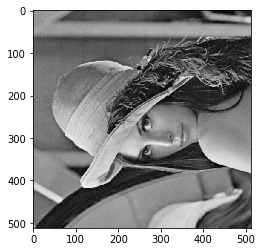

In [7]:
plt.imshow(W.T, cmap = 'gray')

In [8]:
sess = get_session()

In [ ]:
v = tf.reshape(tf.constant(W.T, dtype = tf.float32), (W.shape[1], 1, W.shape[0]))

#filt = tf.reshape(tf.constant([1.,-1]), (-1,1,1))
filt = tf.reshape(tf.constant(gkern(kernlen = 20), dtype = tf.float32), (-1,1,1))

plt.imshow(sess.run(
    tf.nn.convolution(v, filt,padding = 'SAME',
                      data_format = 'NCW')).reshape(W.shape[1], W.shape[0]),
          cmap = 'gray')